In [52]:
import random
import os
import numpy as np

import json
import pickle
import geopandas as gpd
import osmnx as ox

from tqdm import tqdm

In [30]:
def get_end_nodes(G, boba_gdf):
    """
    Return a dict mapping "end nodes" to nodes with boba.
    """
    end_nodes = {}
    nodes = ox.nearest_nodes(G, boba_gdf["geometry"].x, boba_gdf["geometry"].y)

    for i, node in enumerate(nodes):
        shop_id = boba_gdf.iloc[i]["id"]
        end_nodes[node] = shop_id
        for edge in G.in_edges(node):
            end_nodes[edge[0]] = shop_id

    return end_nodes


def angle_diff(a, b):
    diff = a - b
    if diff < -np.pi/2: return diff + np.pi
    if diff > np.pi/2: return diff - np.pi
    return diff


# Keep visiting nodes till we hit something in end_nodes
def random_walk(adj, end_nodes, start, timeout=60*2.5):
    """
    Do a random walk starting from node <start> (node id)
        until we hit a boba shop, hit a dead end, or time out.

    Timeout is in seconds. If we haven't reached a boba shop or
        a dead end by that time, we terminate.
    
    Returns an ordered tuple:
        [0] route:        list of tuples (node id, time)
        [1] total_time:   total amount of time taken
        [2] flag:         "success", "timeout", or "deadend"
    """
    cur = start
    prev = None  # Don't want to go backwards
    cur_time = 0
    cur_angle = None
    route = []

    while True:
        route.append(cur)

        if cur in end_nodes:  # Found a boba shop!
            return route, cur_time, "success"
        if cur_time >= timeout:  # Time exceeded
            return route, cur_time, "timeout"
        if len(adj[cur]) == 0:  # Dead end
            return route, cur_time, "deadend"

        # Out of all neighbors, small angle has higher weighting
        weights = np.ones(len(adj[cur]))
        for i, edge in enumerate(adj[cur]):
            nbr, _, angle = edge
            if cur_angle != None and angle_diff(cur_angle, angle) < np.pi * 1/6:
                weights[i] = 8
            if nbr == prev:
                weights[i] = 0.1

        chosen_edge_idx = np.random.choice(range(len(adj[cur])), p=(weights / weights.sum()))
        nbr, length, _ = adj[cur][chosen_edge_idx]
        cur_time += length / 4 / 1000 * 60  # Walking speed is 4 kph, convert to minutes

        prev = cur
        cur = nbr

In [54]:
with open("./places.json") as fin:
    places = json.load(fin)

for i, place in enumerate(places):
    placename, slug = place
    print(f"===== [{i:>2}/{len(places)}] Simulating walks from {placename} =====")

    print(f"Reading boba locations...")
    boba_gdf = gpd.read_file(
        f"./data/boba/{slug}.csv",
        GEOM_POSSIBLE_NAMES="geometry", 
        KEEP_GEOM_COLUMNS="NO"
    )

    print(f"Reading network...")
    with open(f"./data/networks/{slug}.pkl", "rb") as fin:
        G = pickle.load(fin)

    print(f"Reading adjacency list...")
    with open(f"./data/adj_lists/{slug}.pkl", "rb") as fin:
        adj = pickle.load(fin)
    
    start = ox.nearest_nodes(G, *ox.geocoder.geocode(placename)[::-1])
    end_nodes = get_end_nodes(G, boba_gdf)

    times = []
    steps = []
    flags = []
    for i in tqdm(range(10**5), ncols=100):
        route, total_time, flag = random_walk(adj, end_nodes, start, timeout=60*24)
        times.append(total_time)
        steps.append(len(route))
        flags.append(flag)
    
    print(f"Saving records...")
    os.makedirs(f"./output/walk_runs", exist_ok=True)
    with open(f"./output/walk_runs/{slug}.json", "w") as fout:
        json.dump({
            "times": times,
            "steps": steps,
            "flags": flags
        }, fout, separators=(",", ":"))

    print()

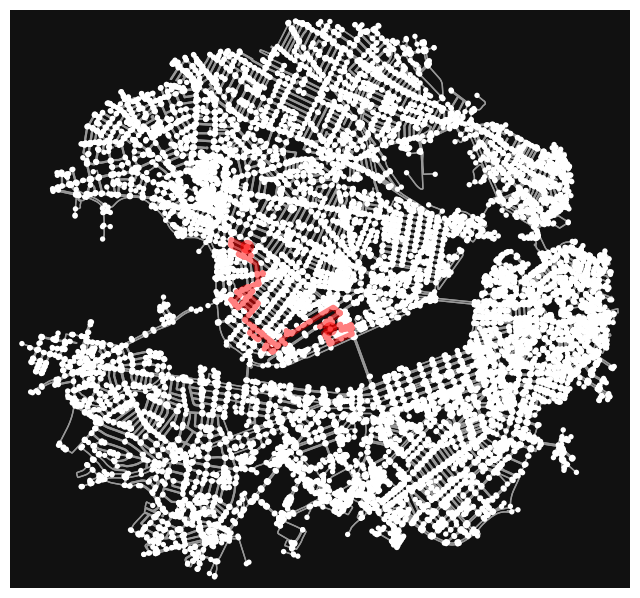

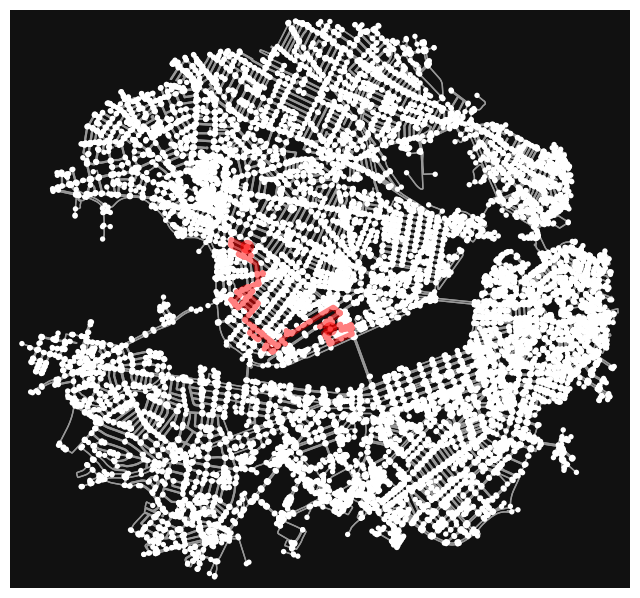

In [50]:
fig, ax = ox.plot_graph(G, show=False)
ox.plot_graph_route(G, walk[0], ax=ax)
fig

In [28]:
adj[8901794207]

[(9468890577, 85.977, -2.753), (8901794215, 7.482, 1.571)]